In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood,infer_LogNorm_params,compute_Loss_grid,Spectra_Loss,compute_Confidence_grid


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

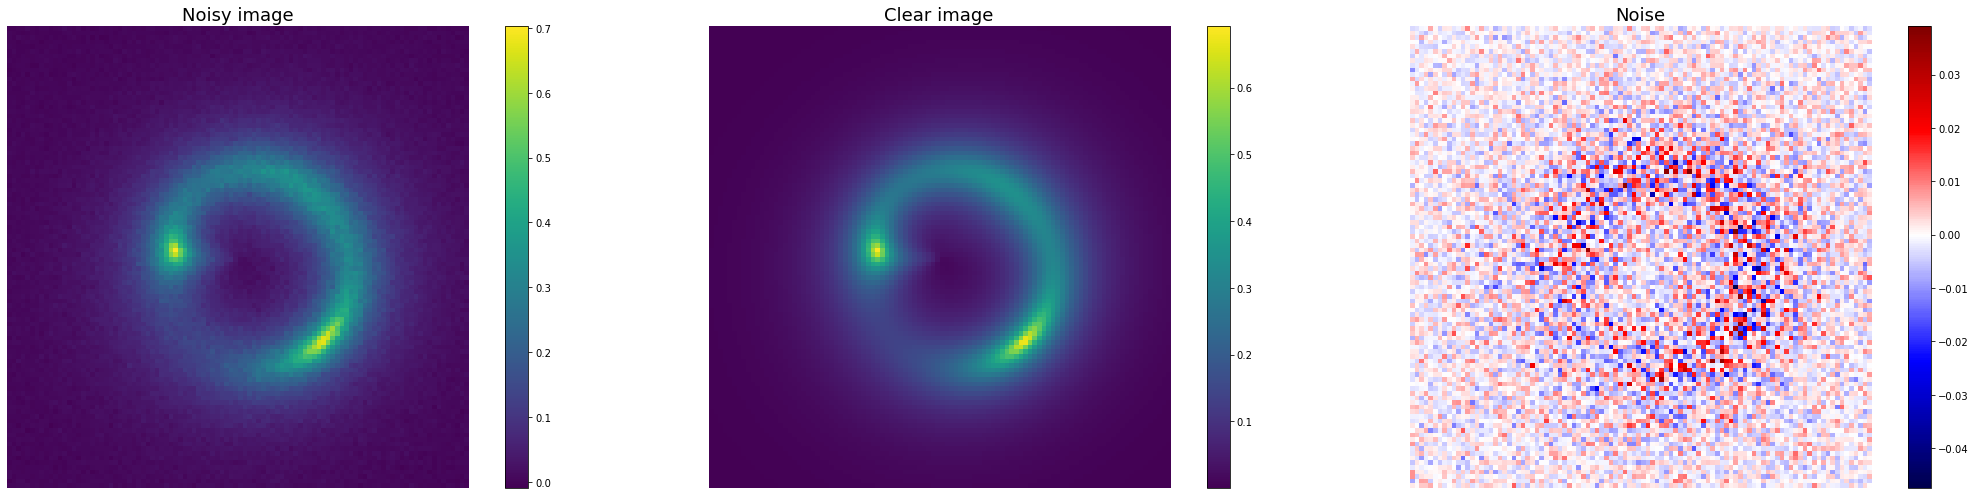

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# GRF Spectra grid

In [143]:
logA_center_array=np.linspace(-9,-6.75,96)
Beta_center_array=np.linspace(1,5,96)

logA_step=logA_center_array[1]-logA_center_array[0]
Beta_step=Beta_center_array[1]-Beta_center_array[0]

Beta_min=1-math.floor(1/Beta_step)*Beta_step

Beta_long_array=np.arange(Beta_min,9,step=Beta_step)
Beta_left_array=np.arange(Beta_min,1,step=Beta_step)
Beta_right_array=np.arange(5+Beta_step,9,step=Beta_step)

logA_up_array=np.arange(-6.75+logA_step,-6.75+logA_step*33,step=logA_step)
logA_down_array=np.arange(-9-logA_step*32,-9,step=logA_step)

def load_zipped_tensors(directory,tensor_name,nodes,batches):
    tensor_array=[]
    
    Spectra_grid=[]
    for node in range(nodes):
        Spectra_node_grid=np.load(directory+'{}_node_{}_batch_0.npz'.format(tensor_name,node))['arr_0']
        for batch in range(1,batches):
            next_grid=np.load(directory+'{}_node_{}_batch_{}.npz'.format(tensor_name,node,batch))
            Spectra_node_grid=np.append(Spectra_node_grid,next_grid['arr_0'],axis=0)
            
        if node==0:
            Spectra_grid=Spectra_node_grid
        else:
            Spectra_grid=np.append(Spectra_grid,Spectra_node_grid,axis=1)
        #Spectra_grid_list+=[Spectra_node_grid]
    
    return Spectra_grid

#Central grid
Spectra_central_fine_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Central_grid/','Spectra_grid',16,3)

#Top/bottom grid
Spectra_top_bot_grid=np.load('data/Spectra_grid_static_noise/Top_bottom_grid/Spectra_grid_node_0.npz')
logA_merged_array=np.append(logA_down_array,logA_up_array)

Spectra_top_grid=Spectra_top_bot_grid['arr_0'][32:]
Spectra_bot_grid=Spectra_top_bot_grid['arr_0'][:32]

#Central left/right grid
Spectra_left_right_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Left_Right_grid/','Spectra_grid',1,3)
Spectra_left_grid=Spectra_left_right_grid[:,:len(Beta_left_array)]
Spectra_right_grid=Spectra_left_right_grid[:,len(Beta_left_array):]

#Combined grid
Spectra_central_grid=np.append(Spectra_left_grid,Spectra_central_fine_grid,axis=1)
Spectra_central_grid=np.append(Spectra_central_grid,Spectra_right_grid,axis=1)

Spectra_full_grid=np.append(Spectra_bot_grid,Spectra_central_grid,axis=0)
Spectra_full_grid=np.append(Spectra_full_grid,Spectra_top_grid,axis=0)

logA_full_array=np.append(logA_down_array,logA_center_array)
logA_full_array=np.append(logA_full_array,logA_up_array)

Beta_full_array=np.append(Beta_left_array,Beta_center_array)
Beta_full_array=np.append(Beta_full_array,Beta_right_array)

print('Spectra grid shape', Spectra_full_grid.shape)
print('log(A) array len', len(logA_full_array))
print('Beta array len',len(Beta_full_array))

del Spectra_central_fine_grid; del Spectra_top_bot_grid; del Spectra_top_grid ;del Spectra_bot_grid; del Spectra_left_right_grid; del Spectra_left_grid; del Spectra_right_grid; del Spectra_central_grid
del logA_center_array; del logA_down_array; del logA_merged_array; del logA_up_array; del logA_step
del Beta_center_array; del Beta_left_array; del Beta_long_array; del Beta_right_array; del Beta_min; del Beta_step

Spectra grid shape (160, 214, 100, 46)
log(A) array len 160
Beta array len 214


In [144]:
logA_array=deepcopy(logA_full_array)
Beta_array=deepcopy(Beta_full_array)

Spectra_grid=deepcopy(Spectra_full_grid)

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)

# GRF grid physical borders

In [145]:
logA_array_original=deepcopy(logA_array)
Beta_array_original=deepcopy(Beta_array)

In [146]:
logA_borders=[-9.7,-6.8]
Beta_borders=[0,4.8]

In [147]:
Coarse_logA_array=(logA_array[::11])[:12]
Coarse_Beta_array=(Beta_array[::11])[:11]

In [148]:
logA_array_restricted=logA_array[:-34]
Beta_array_restricted=Beta_array[:115]

In [149]:
Spectra_grid_restricted=Spectra_grid[:-34,:115]

In [150]:
#np.savez('./data/Loss_tensor',Loss_tensor)
Loss_tensor=np.load('./data/Loss_tensor.npz')['arr_0']

In [151]:
Loss_tensor=Loss_tensor[:12,:11,:,:-34,:115]

In [152]:
logA_array=logA_array_restricted
Beta_array=Beta_array_restricted

# Inference prediction grid

In [153]:
SNR_grid=compute_SNR_grid(Spectra_grid_restricted,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:72: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


## Prediction bias

In [155]:
def inference_over_seeds(Spectra_phase_row,Spectra_grid_shape):
    gamma_data,mu_data,sigma_data=infer_LogNorm_params(Spectra_phase_row)
    def func(data_spec):
        logSpec_data=jnp.log(data_spec)
        Spectra_Loss_pure=lambda model_spectra: Spectra_Loss(model_spectra,logSpec_data,sigma_data)
           
        Loss_grid=compute_Loss_grid(Spectra_grid,Spectra_Loss_pure)
        #results=inference_results(Spectra_grid,Spectra_Loss_pure,Spectra_grid_shape)
        return Loss_grid
    
    return jax_map(func,Spectra_phase_row)

In [156]:
'''
Loss_tensor=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,len(logA_array),len(Beta_array)))
Spectra_grid_shape=Spectra_grid.shape

for i,logA_index in tqdm(enumerate(range(0,len(logA_array),11))):
    
    map_over_beta=lambda Spectra_phase_row: inference_over_seeds(Spectra_phase_row,Spectra_grid_shape)
    Loss_row=jax_map(map_over_beta,Spectra_grid[logA_index,::11])
    Loss_tensor[i]=Loss_row
'''

'\nLoss_tensor=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,len(logA_array),len(Beta_array)))\nSpectra_grid_shape=Spectra_grid.shape\n\nfor i,logA_index in tqdm(enumerate(range(0,len(logA_array),11))):\n    \n    map_over_beta=lambda Spectra_phase_row: inference_over_seeds(Spectra_phase_row,Spectra_grid_shape)\n    Loss_row=jax_map(map_over_beta,Spectra_grid[logA_index,::11])\n    Loss_tensor[i]=Loss_row\n'

In [157]:
Loss_tensor.shape

(12, 11, 100, 126, 115)

In [158]:
def get_cdf(likelihood):
    cdf=np.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]
    
    return normalised_cdf

def get_prediction(cdf,pred_index,precentage_covered):
    #indent=np.minimum(0.5,percentage_covered/200.)
    indent=precentage_covered/200.
    
    upper_index=np.where(cdf<=cdf[pred_index]+indent)[0][-1]
    lower_index=np.where(cdf>=cdf[pred_index]-indent)[0][0]
    
    return lower_index,upper_index

def get_conf_intervals(likelihood_grid):
    
    Beta_cdf=get_cdf(likelihood.mean(axis=0))
    Beta_pred_index=np.argmin(np.abs(Beta_cdf-0.5))
    

    logA_cdf=get_cdf(likelihood.mean(axis=1))
    logA_pred_index=np.argmin(np.abs(logA_cdf-0.5))
    
    percentage_covered=[68,95,99.7]
    Beta_conf_regions=np.zeros((3,2))
    logA_conf_regions=np.zeros((3,2))
    
    for i in range(3):
        Beta_conf_regions[i]=get_prediction(Beta_cdf,Beta_pred_index,percentage_covered[i])
        logA_conf_regions[i]=get_prediction(logA_cdf,logA_pred_index,percentage_covered[i])
    
    return logA_pred_index,Beta_pred_index,logA_conf_regions.astype(int),Beta_conf_regions.astype(int)

In [160]:
Coarse_logA_array.shape

(12,)

In [161]:
Coarse_Beta_array.shape

(11,)

In [162]:
logA_array.shape

(126,)

Text(0.4, 1.0, 'Likelihood')

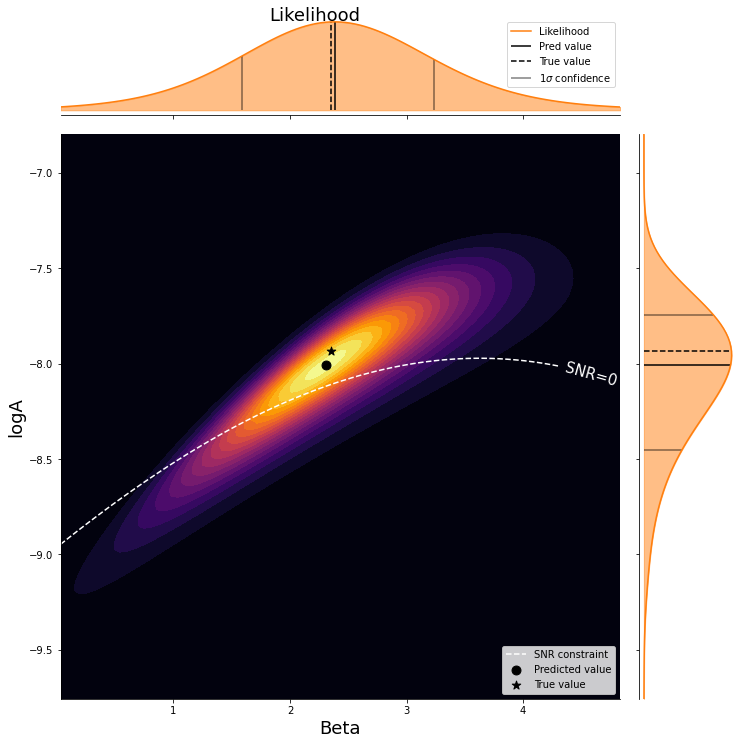

In [167]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage
%matplotlib inline


xlim=(1,5)
ylim=(-9,-6.75)

i=7
j=5
phi_ind=4


GRF_params=[Coarse_logA_array[i],Coarse_Beta_array[j]]


true_logA_index=np.where(logA_array==GRF_params[0])[0]
true_Beta_index=np.where(Beta_array==GRF_params[1])[0]

loss=Loss_tensor[i,j,phi_ind]

pred_logA_index,pred_Beta_index=np.unravel_index(np.argmin(loss),loss.shape)

likelihood=np.exp(-loss/2)
#max_likelihood=(likelihood.max()*2).round(1)/2

#Likelihood

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_array,logA_array,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')

#SNR constraint

img=g.ax_joint.contour(Beta_array,logA_array,SNR_grid,[0],colors='w',linestyles='--')
img.collections[0].set_label('SNR constraint')

fmt = {}
strs = ['SNR=0']
for l,s in zip( img.levels, strs ):
    fmt[l] = s

manual_locations=[(10,4)]
g.ax_joint.clabel(img,[0],inline=1,fontsize=15,fmt=fmt,manual=manual_locations)

#Prediction and truth


g.ax_joint.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='True value',marker="*",s=80,color='k')


logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_array,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_array,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_array[Beta_pred_index],0,Beta_likelihood[Beta_pred_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')

for i in range(1):
    g.ax_marg_x.vlines(Beta_array[Beta_conf_regions[i,0]],0,Beta_likelihood[Beta_conf_regions[i,0]],color='black',alpha=0.5,label=r'$1\sigma$'+' confidence')
    g.ax_marg_x.vlines(Beta_array[Beta_conf_regions[i,1]],0,Beta_likelihood[Beta_conf_regions[i,1]],color='black',alpha=0.5)


g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_array,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_array,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_array[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


for i in range(1):
    g.ax_marg_y.hlines(logA_array[logA_conf_regions[i,0]],0,logA_likelihood[logA_conf_regions[i,0]],color='black',alpha=0.5,label=r'$1\sigma$'+' confidence')
    g.ax_marg_y.hlines(logA_array[logA_conf_regions[i,1]],0,logA_likelihood[logA_conf_regions[i,1]],color='black',alpha=0.5)


#Grid labels

g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

In [168]:
logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

In [169]:
print(true_logA_index,true_Beta_index)
print(logA_pred_index,Beta_pred_index)

[77] [55]
72 56


In [170]:
print(logA_conf_regions)

[[55 85]
 [30 95]
 [ 0 99]]


In [171]:
cdf=get_cdf(likelihood.mean(axis=0))

In [172]:
pred_Beta_index=np.argmin(np.abs(cdf-0.5))
indent=99.7/200
upper_index=np.where(cdf<=cdf[pred_Beta_index]+indent)[0][-1]
lower_index=np.where(cdf>=cdf[pred_Beta_index]-indent)[0][0]

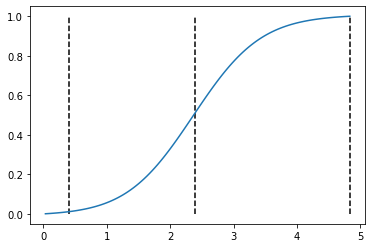

In [173]:
plt.plot(Beta_array,cdf)
plt.vlines(Beta_array[pred_Beta_index],0,1,color='k',linestyle='--')
plt.vlines(Beta_array[upper_index],0,1,color='k',linestyle='--')
plt.vlines(Beta_array[lower_index],0,1,color='k',linestyle='--')

In [174]:
pred_Beta_index=np.argmin(np.abs(cdf-0.5))

In [175]:
upper_index=np.where(cdf<=cdf[pred_Beta_index]+0.34)[0][-1]
lower_index=np.where(cdf>=cdf[pred_Beta_index]-0.34)[0][0]

In [176]:
upper_index

76

In [177]:
pred_Beta_index

56

In [178]:
predicted_indices=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],2))
logA_confidence_regions=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],3,2))
Beta_confidence_regions=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],3,2))



for i,_ in tqdm(enumerate(Coarse_logA_array)):
    for j,_ in enumerate(Coarse_Beta_array):
        for k in range(100):
            
            likelihood=np.exp(-Loss_tensor[i,j,k]/2)
            logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)
            
            predicted_indices[i,j,k]=[logA_pred_index,Beta_pred_index]
            logA_confidence_regions[i,j,k]=logA_conf_regions
            Beta_confidence_regions[i,j,k]=logA_conf_regions
            


12it [00:11,  1.08it/s]


In [179]:
'''np.savez('./data/median_predictions',predicted_indices=predicted_indices,\
         logA_confidence_regions=logA_confidence_regions,
         Beta_confidence_regions=Beta_confidence_regions)'''

In [15]:
'''predictions=np.load('./data/predictions.npz')
predicted_indices=predictions['predicted_indices']
one_sigma_border_indices=predictions['one_sigma_border_indices']
two_sigma_border_indices=predictions['two_sigma_border_indices']
three_sigma_border_indices=predictions['three_sigma_border_indices']'''

In [180]:
predictions=np.load('./data/median_predictions.npz')
predicted_indices=predictions['predicted_indices']
logA_confidence_regions=predictions['logA_confidence_regions']
Beta_confidence_regions=predictions['Beta_confidence_regions']

In [181]:
true_indices=np.array([np.arange(0,len(logA_array),11),np.arange(0,len(Beta_array),11)])

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31299/1525615207.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  true_indices=np.array([np.arange(0,len(logA_array),11),np.arange(0,len(Beta_array),11)])


# Median likelihood and 1d contours

## Bias and uncertainty

In [190]:
predicted_bias=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,2))

uncertainty_width=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(Coarse_logA_array)):
    for j in range(len(Coarse_Beta_array)):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-true_indices[0][i])
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-true_indices[1][j])

## Bias

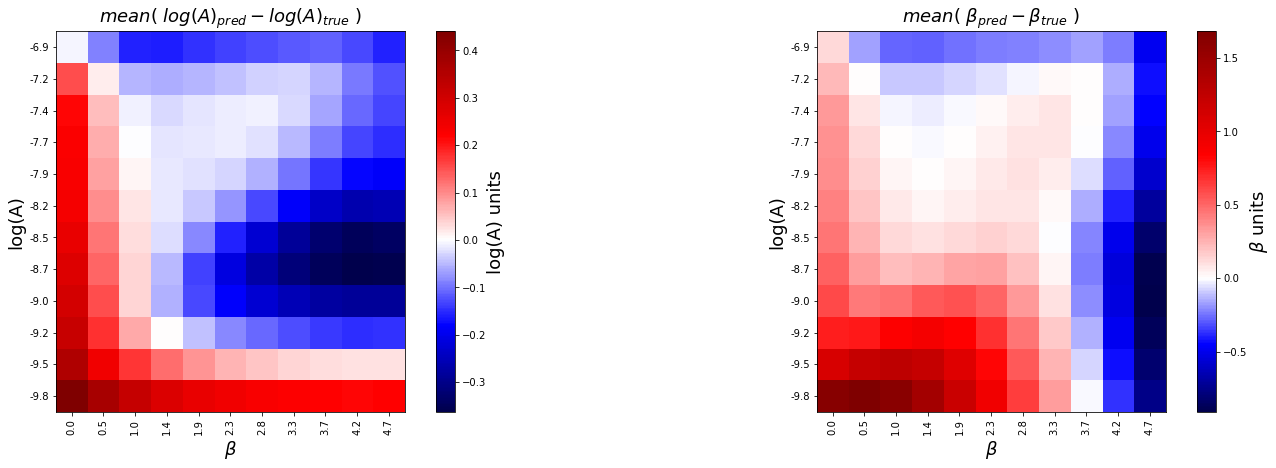

In [194]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

mean_bias=predicted_bias.mean(axis=-2)

img_arr+=[ax[0].imshow(mean_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(mean_bias[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

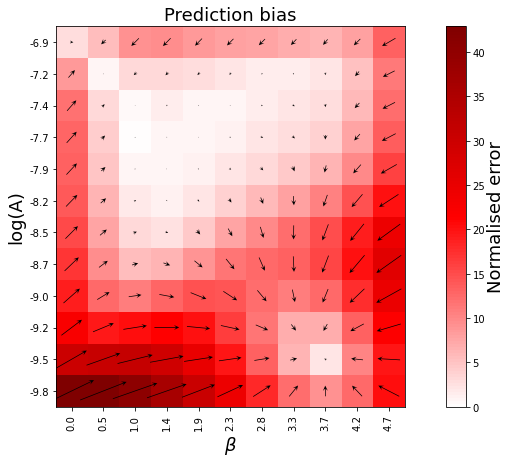

In [195]:
plt.figure(figsize=(15,7))
X,Y=np.meshgrid(Coarse_Beta_array,Coarse_logA_array)
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]

img=plt.imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1)
plt.quiver(I, J,scale=300,width=0.002,headwidth=7,headlength=7.5,pivot='middle')


plt.gca().patch.set(hatch="+", edgecolor='black',alpha=0.05)

plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=FS,labelpad=2)
plt.show()

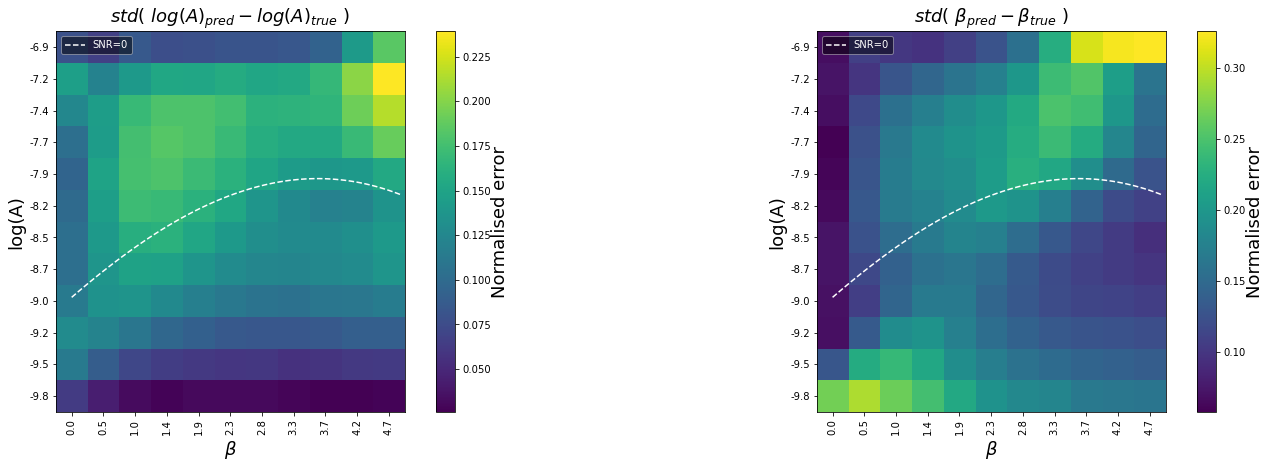

In [197]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

img_arr+=[ax[0].imshow(std_bias[:,:,0])]
img_arr+=[ax[1].imshow(std_bias[:,:,1])]

#img_arr+=[ax[0].imshow(Perturbation_matrix*std_bias[:,:,0])]
#img_arr+=[ax[1].imshow(Perturbation_matrix*std_bias[:,:,1])]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised error','Normalised error']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    #l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

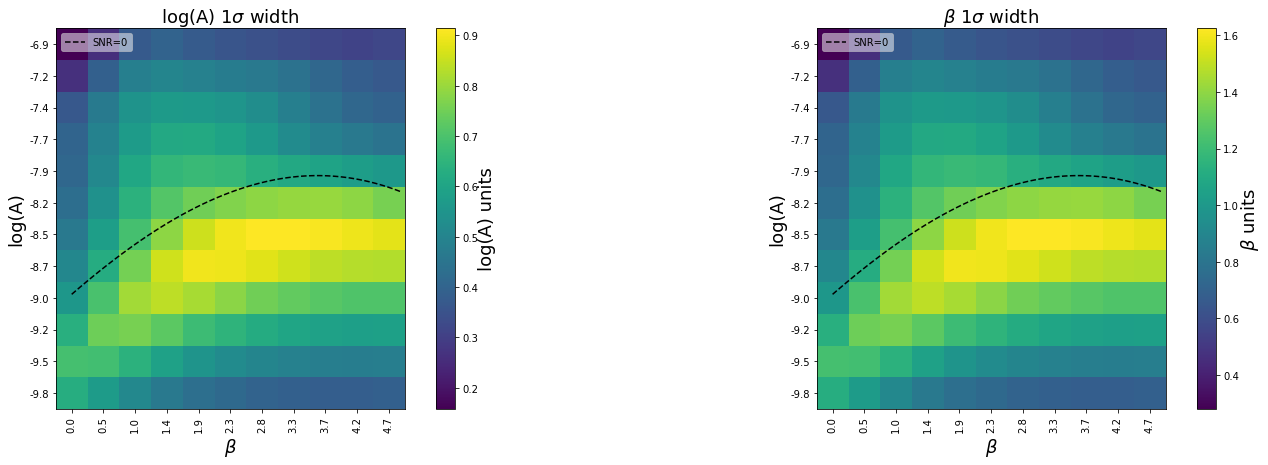

In [209]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=1
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

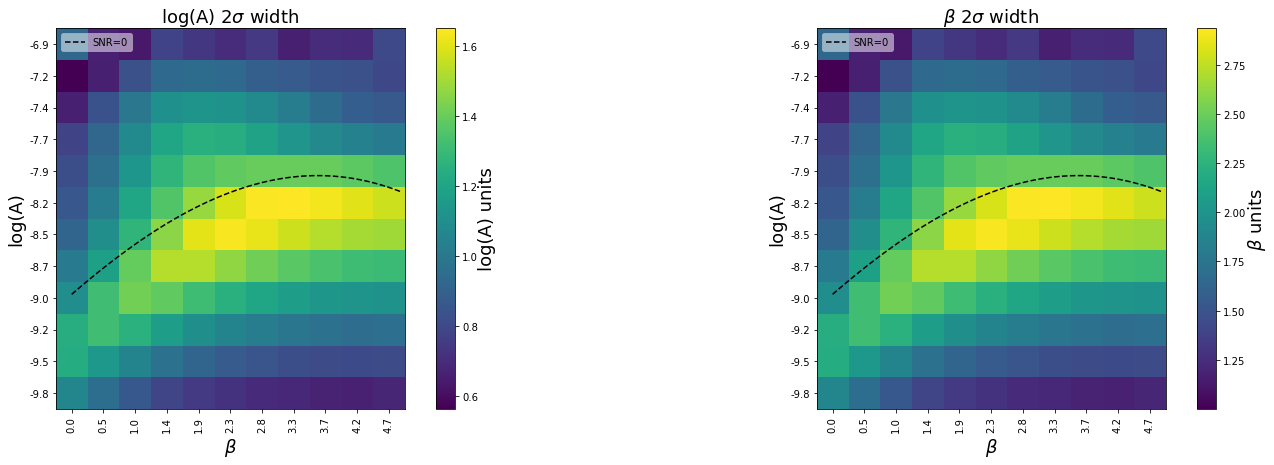

In [210]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=2
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

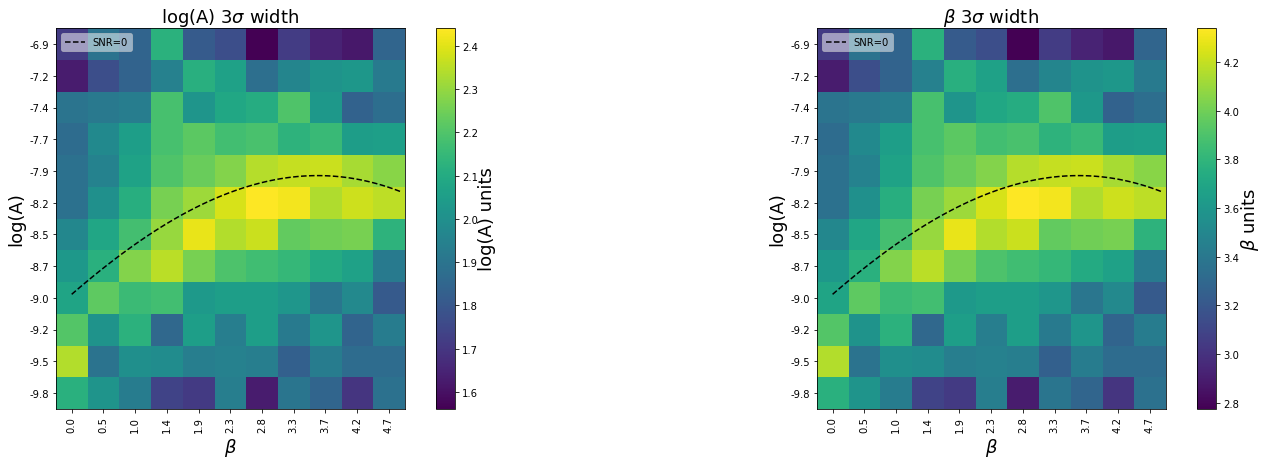

In [211]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=3
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)